# Data Cleansing with R

In [5]:
library(dplyr)
library(ggplot2)
if(!require(ggExtra)) {install.packages("ggExtra");require(ggExtra)}
if(!require(naniar)) {install.packages("naniar");require(naniar)}
if(!require(mvoutlier)) {install.packages("mvoutlier");require(mvoutlier)}
if(!require(MissMech)) {install.packages("MissMech");require(MissMech)}
if(!require(mice)) {install.packages("mice");require(mice)}
if(!require(MatchIt)) {install.packages("MatchIt");require(MatchIt)}

Warning message:
"package 'dplyr' was built under R version 4.0.2"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'ggplot2' was built under R version 4.0.2"
Loading required package: ggExtra

Warning message:
"package 'ggExtra' was built under R version 4.0.2"
Loading required package: naniar

Warning message:
"package 'naniar' was built under R version 4.0.2"
Loading required package: mvoutlier

Loading required package: sgeostat

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

sROC 0.1-2 loaded

Loading required package: MissMech

Loading required package: mice


Attaching package: 'mice'


The following objects are masked from 'package:base':

    cbind, rbind


Loading required package: MatchIt



In [6]:
outlierMatrix <- function(data,threshold=1.5) {
    vn <- names(data)
    outdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        if(is.numeric(data[[v]])) {
            outlow <- quantile(data[[v]],probs = 0.25,na.rm = T) 
            outhigh <- quantile(data[[v]],probs = 0.75, na.rm = T)
            irq_level <- (outhigh - outlow) * threshold
            outlow <- outlow - irq_level
            outhigh <- outhigh +  irq_level
            mv <- ifelse(data[[v]] < outlow | data[[v]] > outhigh, 1, 0)
            outdata[v] <- mv
        } else {
            mv <- rep(0,nrow(data))
        }
    }
    outdata$row1 <- NULL
    return(outdata)
}


missingMatrix <- function(data) {
    vn <- names(data)
    missdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        mv <- ifelse(is.na(data[[v]]),1,0)
        missdata[v] <- mv
    }
    missdata$row1 <- NULL
    return(missdata)
}

minmax <- function(x) {
    return(((x-min(x,na.rm=T))/(max(x,na.rm=T)-min(x,na.rm=T))))
}

getMissingness <- function (data, getRows = FALSE) {
    require(dplyr)
    l <- nrow(data)
    vn <- names(data)
    nadf <- data
    cnt <- NULL
    miss <- function(x) return(sum(is.na(x)))
    for (n in vn) {
        nadf[[n]] <- ifelse(is.na(nadf[[n]]) == T, 1, 0)
        cnt <- rbind(cnt, data.frame(n, sum(nadf[[n]])))
    }
    names(cnt) <- c("var", "na.count")
    cnt$rate <- round((cnt$na.count/nrow(nadf)) * 100, 1)
    nadf$na.cnt <- 0
    nadf$na.cnt <- rowSums(nadf)
    cnt <- cnt %>% dplyr::arrange(desc(na.count)) %>% dplyr::filter(na.count > 
        0)
    totmiss <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::tally()
    idx <- NULL
    msg <- (paste("This dataset has ", as.character(totmiss), 
        " (", as.character(round(totmiss/nrow(data) * 100, 1)), 
        "%)", " complete rows. Original data has ", nrow(data), 
        " rows.", sep = ""))
    if (getRows == TRUE & totmiss != 0) {
        nadf$rn <- seq_len(nrow(data))
        idx <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::select(rn)
    }
    print(list(head(cnt, n = 10), msg))
    return(list(missingness = cnt, message = msg, rows = idx$rn))
}

In [7]:
### load data
animals = mice::mammalsleep
#animals = read.csv("../data/mammalsleep.csv")
animals$X <- NULL
head(animals)

,species,bw,brw,sws,ps,ts,mls,gt,pi,sei,odi
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,African elephant,6654.000,5712.0,NA,NA,3.3,38.6,645,3,5,3
2,African giant pouched rat,1.000,6.6,6.3,2.0,8.3,4.5,42,3,1,3
3,Arctic Fox,3.385,44.5,NA,NA,12.5,14.0,60,1,1,1
4,Arctic ground squirrel,0.920,5.7,NA,NA,16.5,NA,25,5,2,3
5,Asian elephant,2547.000,4603.0,2.1,1.8,3.9,69.0,624,3,5,4
6,Baboon,10.550,179.5,9.1,0.7,9.8,27.0,180,4,4,4


# Outliers

## Univariate Outliers

In [8]:
## Using IRQ for catching univariate outliers (1.5 x IRQ)
head(outlierMatrix(animals,threshold=1.5))

,bw,brw,sws,ps,ts,mls,gt,pi,sei,odi
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,NA,NA,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,NA,NA,0,0,0,0,0,0
4,0,0,NA,NA,0,NA,0,0,0,0
5,1,1,0,0,0,1,1,0,0,0
6,0,0,0,0,0,0,0,0,0,0


In [9]:
## Using IRQ for catching univariate outliers (1.5 x IRQ)
head(outlierMatrix(animals,threshold=2.0))

,bw,brw,sws,ps,ts,mls,gt,pi,sei,odi
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,NA,NA,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,NA,NA,0,0,0,0,0,0
4,0,0,NA,NA,0,NA,0,0,0,0
5,1,1,0,0,0,0,1,0,0,0
6,0,0,0,0,0,0,0,0,0,0


In [10]:
animal2 <- animals
animal2$sws <- ifelse(is.na(animal2$sws)==TRUE, 0,1)
animal2$ps <- ifelse(is.na(animal2$ps)==TRUE, 0,1)
animal2$mls <- ifelse(is.na(animal2$mls)==TRUE, 0,1)

animal2

species,bw,brw,sws,ps,ts,mls,gt,pi,sei,odi
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
African elephant,6654.000,5712.0,0,0,3.3,1,645,3,5,3
African giant pouched rat,1.000,6.6,1,1,8.3,1,42,3,1,3
Arctic Fox,3.385,44.5,0,0,12.5,1,60,1,1,1
Arctic ground squirrel,0.920,5.7,0,0,16.5,0,25,5,2,3
Asian elephant,2547.000,4603.0,1,1,3.9,1,624,3,5,4
Baboon,10.550,179.5,1,1,9.8,1,180,4,4,4
Big brown bat,0.023,0.3,1,1,19.7,1,35,1,1,1
Brazilian tapir,160.000,169.0,1,1,6.2,1,392,4,5,4
Cat,3.300,25.6,1,1,14.5,1,63,1,2,1


bw,brw,sws,ps,ts,mls,gt,pi,sei,odi
1,1,1,1,0,0,1,0,0,0
0,0,0,0,0,0,0,0,0,0
0,0,1,1,0,0,0,0,0,0
0,0,1,1,0,1,0,0,0,0
1,1,0,0,0,0,1,0,0,0
0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0


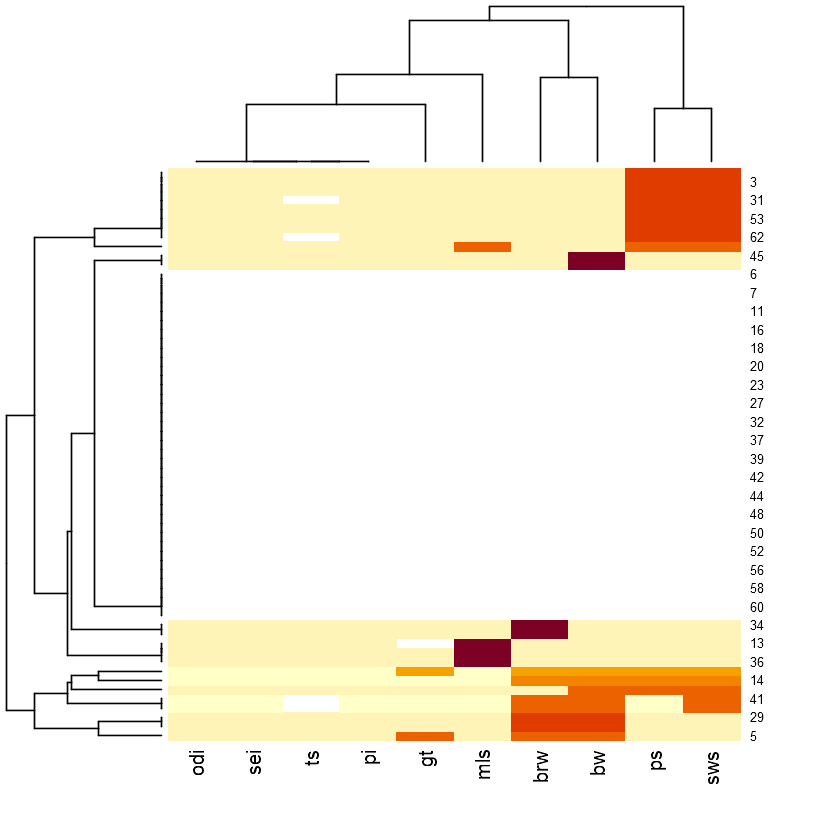

In [11]:
as.matrix(outlierMatrix(animal2[,2:11],threshold=1.5))
heatmap(as.matrix(outlierMatrix(animal2[,2:11],threshold=1.5)),na.rm = T)

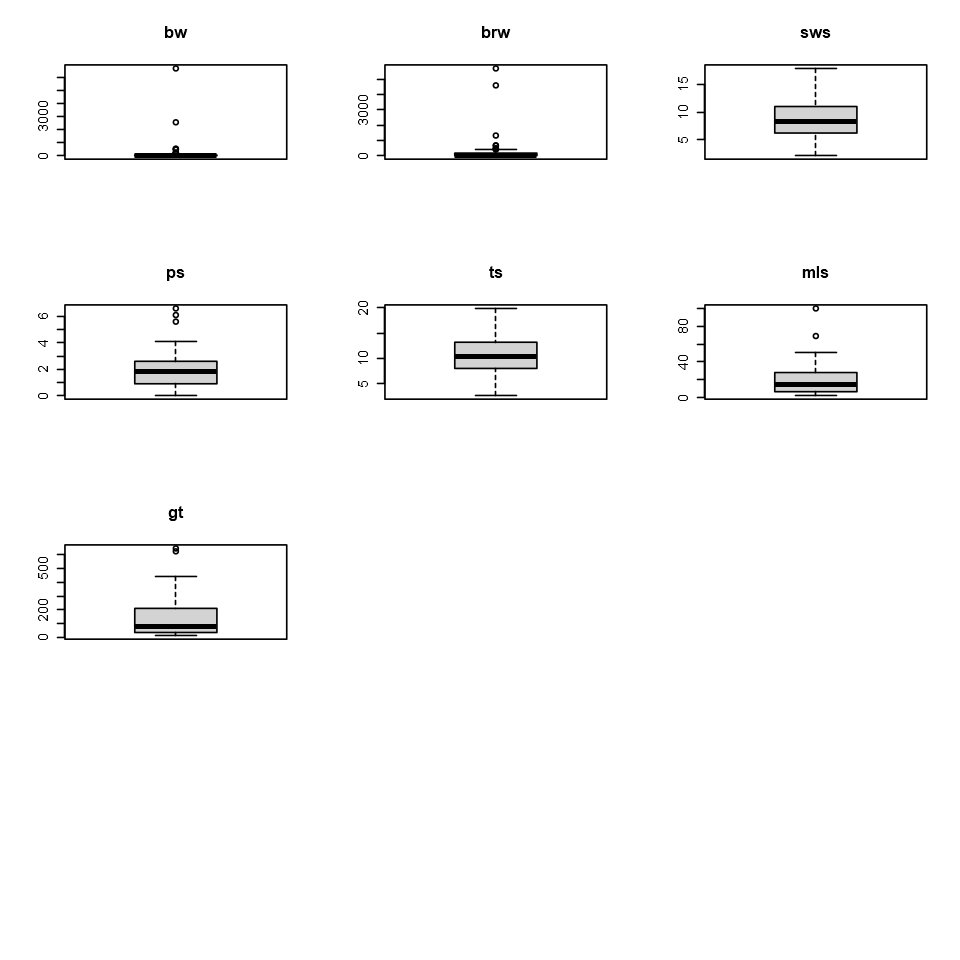

In [12]:
## Visual determination of univariate outliers using boxplots 
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(4,3))
for(v in names(animals[,2:8])) {
    boxplot(animals[[v]],main=v)
}
par(mfrow=c(1,1))


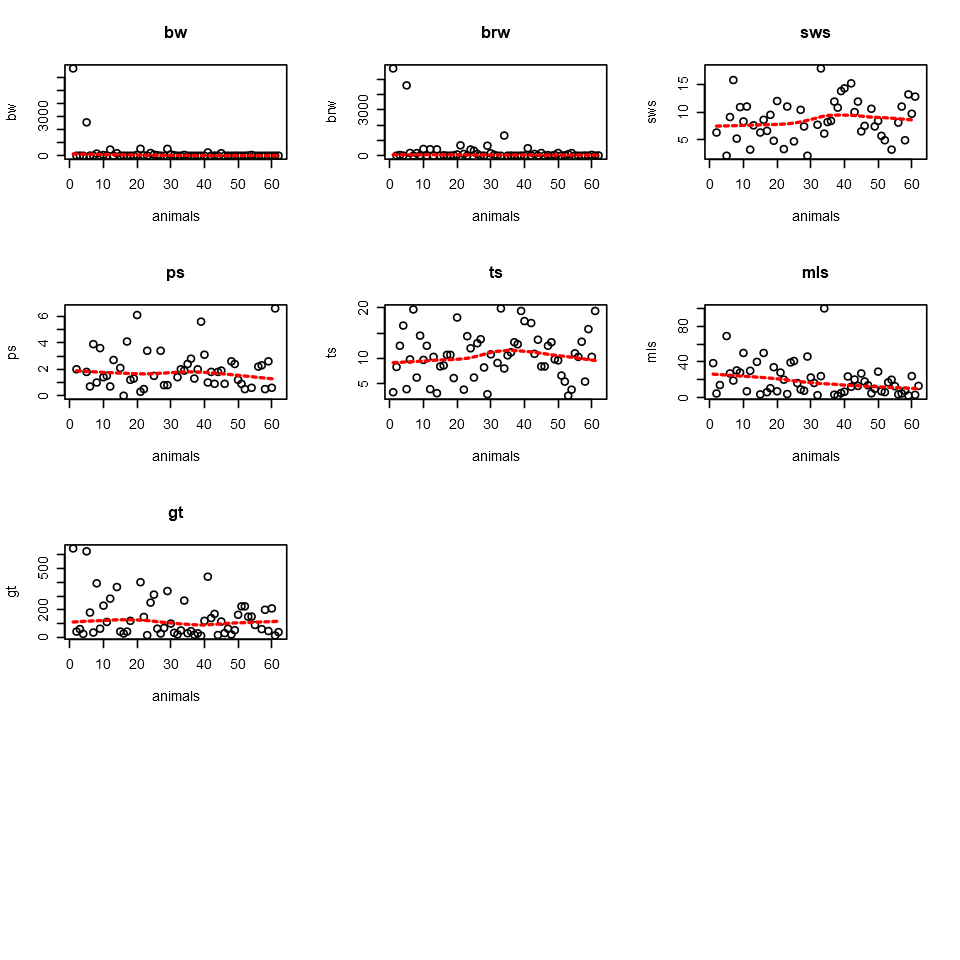

In [13]:
## Visual determination of univariate outliers using scatter plots 
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(4,3))
for(v in names(animals[,2:8])) {
    scatter.smooth(animals[[v]] ~ animals$species, main=v, xlab="animals",ylab=v, family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2))
}
par(mfrow=c(1,1))


## Multivariate Outliers
 
### Detecting multivariate outliers using DBSCAN

In [14]:
## dbscan
library(dbscan)
# normalize the numbers
animals.norm <- sapply(animals[,2:ncol(animals)], minmax)

Warning message:
"package 'dbscan' was built under R version 4.0.2"


In [15]:
head(animals.norm)

bw,brw,sws,ps,ts,mls,gt,pi,sei,odi
1.0000000000,1.0000000000,NA,NA,0.04046243,0.3734694,1.00000000,0.50,1.00,0.50
0.0001495342,0.0011309801,0.2658228,0.3030303,0.32947977,0.0255102,0.04739336,0.50,0.00,0.50
0.0005079655,0.0077662968,NA,NA,0.57225434,0.1224490,0.07582938,0.00,0.00,0.00
0.0001375114,0.0009734132,NA,NA,0.80346821,NA,0.02053712,1.00,0.25,0.50
0.3827768130,0.8058425802,0.0000000,0.2727273,0.07514451,0.6836735,0.96682464,0.50,1.00,0.75
0.0015847622,0.0314013299,0.4430380,0.1060606,0.41618497,0.2551020,0.26540284,0.75,0.75,0.75


In [16]:
mm <- getMissingness(animals, getRows = T)
head(mm$rows)

[[1]]
  var na.count rate
1 sws       14 22.6
2  ps       12 19.4
3  ts        4  6.5
4 mls        4  6.5
5  gt        4  6.5

[[2]]
[1] "This dataset has 42 (67.7%) complete rows. Original data has 62 rows."



[1] 2 5 6 7 8 9

In [17]:
mod <- dbscan(animals.norm[mm$rows,], eps=0.5, minPts = 4)
table(mod$cluster)


 0  1  2 
 6 23 13 

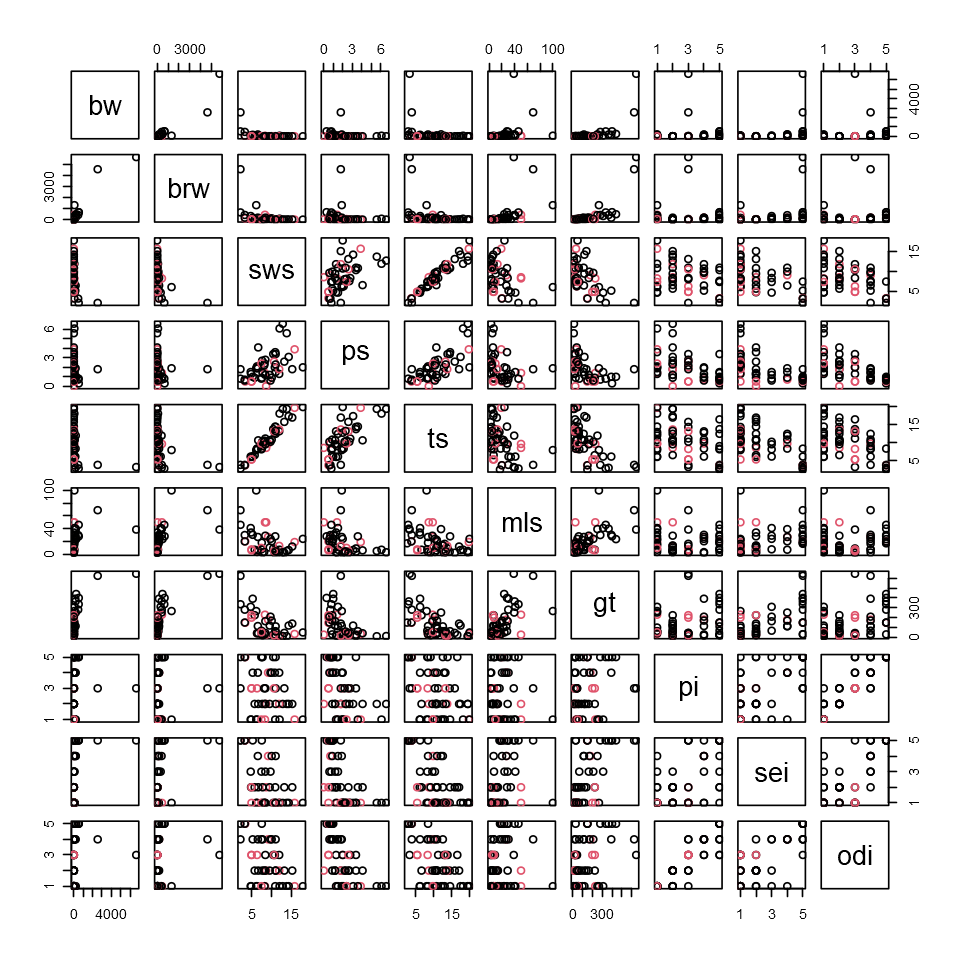

In [18]:
options(repr.plot.width = 8, repr.plot.height = 8)
pairs(animals[,2:ncol(animals)], col=ifelse(mod$cluster==0,2,1))


### Detecting multivariate outliers using Chi-squre distance plot

Warning message in covMcd(x, alpha = quan):
"The covariance matrix of the data is singular.
There are 42 observations (in the entire dataset of 42 obs.) lying on
the hyperplane with equation a_1*(x_i1 - m_1) + ... + a_p*(x_ip - m_p)
= 0 with (m_1, ..., m_p) the mean of these observations and
coefficients a_i from the vector a <- c(0, -0.6491074, -0.2711461,
0.7107315, 0)"


NULL

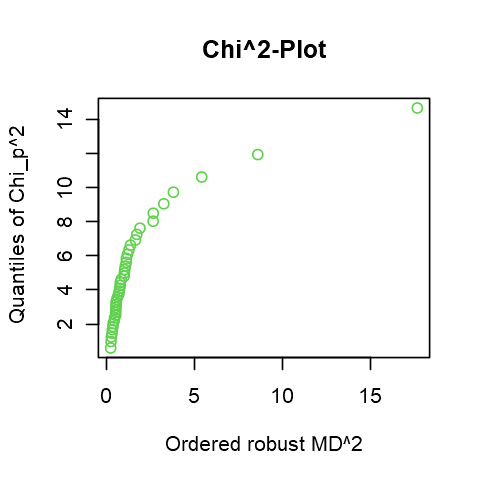

In [19]:
options(repr.plot.width = 4, repr.plot.height = 4)
res <-chisq.plot(animals.norm[mm$rows,2:6],ask=F)
res$outliers

### Detecting multivariate outliers using DIstance-Distance plots
 
This plot measures the distance between a point and a distribution to which that point belongs. To do this it uses the Mahalonobis distance
 

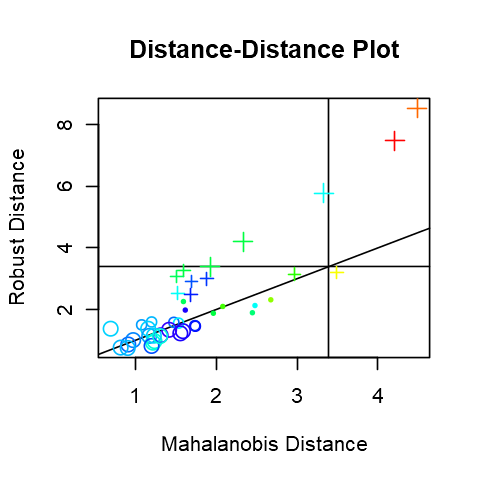

In [20]:
## Distance-Distance plot for outlier detection
options(repr.plot.width = 4, repr.plot.height = 4)
animals2 <- animals[mm$rows,c(4,5,7,8)]
distances <- dd.plot(animals2, quan=1/2, alpha=0.025)

## Multivariate Outliers detection using PCA

In [21]:
animals.pca <- prcomp(animals[mm$rows,2:ncol(animals)])

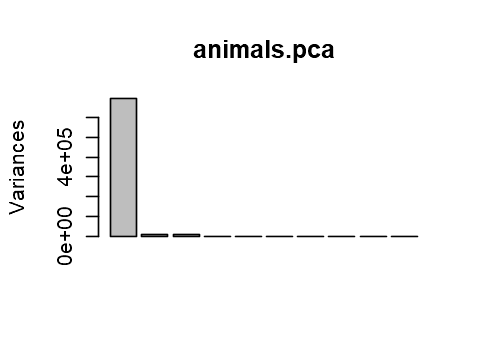

In [22]:
options(repr.plot.width = 4, repr.plot.height = 3)
plot(animals.pca)

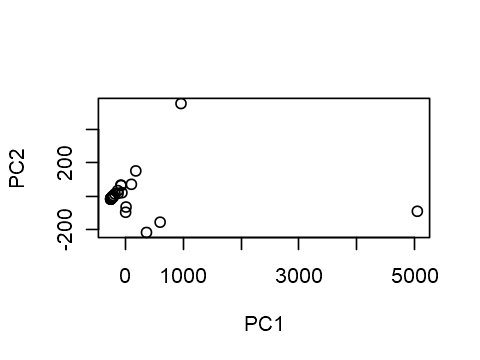

In [23]:
plot(animals.pca$x)

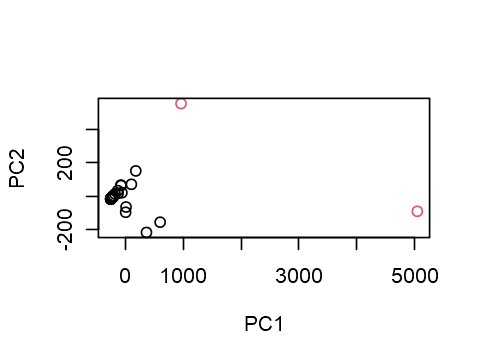

In [24]:
outliers <- ifelse(animals.pca$x[,1]>800,2,1)
plot(animals.pca$x, col=outliers)

# Missingness

In [25]:
head(missingMatrix(animals))

,species,bw,brw,sws,ps,ts,mls,gt,pi,sei,odi
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,0,0,0,0
4,0,0,0,1,1,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0


In [26]:
animal_na <- missingMatrix(animals)
nm <- paste(names(animals),"na",sep="_")
names(animal_na) <- nm

In [27]:
head(animal_na)

,species_na,bw_na,brw_na,sws_na,ps_na,ts_na,mls_na,gt_na,pi_na,sei_na,odi_na
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,0,0,0,0
4,0,0,0,1,1,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0


In [28]:
animal3 <- cbind(animals,animal_na)

In [29]:
head(animal3)

,species,bw,brw,sws,ps,ts,mls,gt,pi,sei,...,bw_na,brw_na,sws_na,ps_na,ts_na,mls_na,gt_na,pi_na,sei_na,odi_na
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,African elephant,6654.000,5712.0,NA,NA,3.3,38.6,645,3,5,...,0,0,1,1,0,0,0,0,0,0
2,African giant pouched rat,1.000,6.6,6.3,2.0,8.3,4.5,42,3,1,...,0,0,0,0,0,0,0,0,0,0
3,Arctic Fox,3.385,44.5,NA,NA,12.5,14.0,60,1,1,...,0,0,1,1,0,0,0,0,0,0
4,Arctic ground squirrel,0.920,5.7,NA,NA,16.5,NA,25,5,2,...,0,0,1,1,0,1,0,0,0,0
5,Asian elephant,2547.000,4603.0,2.1,1.8,3.9,69.0,624,3,5,...,0,0,0,0,0,0,0,0,0,0
6,Baboon,10.550,179.5,9.1,0.7,9.8,27.0,180,4,4,...,0,0,0,0,0,0,0,0,0,0


Warning message:
"Removed 4 rows containing non-finite values (stat_density)."


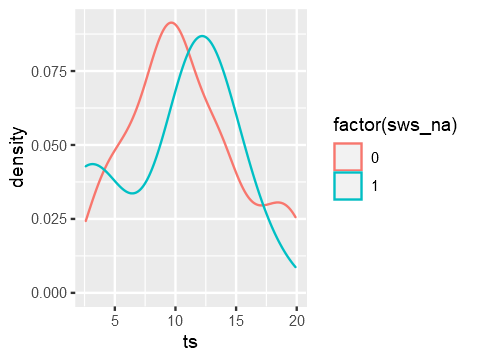

In [30]:
ggplot(animal3, aes(x=ts, group=factor(sws_na), color=factor(sws_na))) +
  geom_density()

In [31]:
mod1 <- glm(ts_na ~ bw + brw + ps + gt + sws +pi+sei+odi, data= animal3, family="binomial")
summary(mod1)


Call:
glm(formula = ts_na ~ bw + brw + ps + gt + sws + pi + sei + odi, 
    family = "binomial", data = animal3)

Deviance Residuals: 
       Min          1Q      Median          3Q         Max  
-2.409e-06  -2.409e-06  -2.409e-06  -2.409e-06  -2.409e-06  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)
(Intercept) -2.657e+01  3.609e+05       0        1
bw          -9.641e-19  5.365e+02       0        1
brw         -8.413e-18  2.964e+02       0        1
ps           4.806e-15  6.071e+04       0        1
gt           3.727e-17  8.969e+02       0        1
sws         -1.155e-15  2.066e+04       0        1
pi          -2.576e-14  1.303e+05       0        1
sei         -1.015e-14  7.306e+04       0        1
odi          4.036e-14  1.755e+05       0        1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 0.0000e+00  on 43  degrees of freedom
Residual deviance: 2.5527e-10  on 35  degrees of freedom
  (18 observations deleted due to missingnes

In [32]:
mm <- getMissingness(animals, getRows = TRUE)

[[1]]
  var na.count rate
1 sws       14 22.6
2  ps       12 19.4
3  ts        4  6.5
4 mls        4  6.5
5  gt        4  6.5

[[2]]
[1] "This dataset has 42 (67.7%) complete rows. Original data has 62 rows."



In [33]:
mm$rows

[1]  2  5  6  7  8  9 10 11 12 15 16 17 18 22 23 25 27 28 29 32 33 34 37 38 39
[26] 40 42 43 44 45 46 48 49 50 51 52 54 57 58 59 60 61

## Missing values visualization

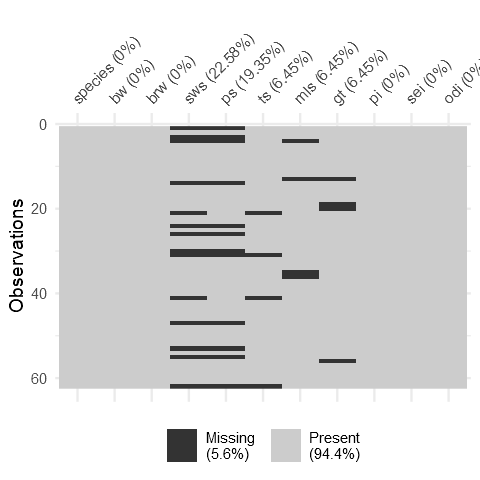

In [34]:
options(repr.plot.width = 4, repr.plot.height = 4)
vis_miss(animals)

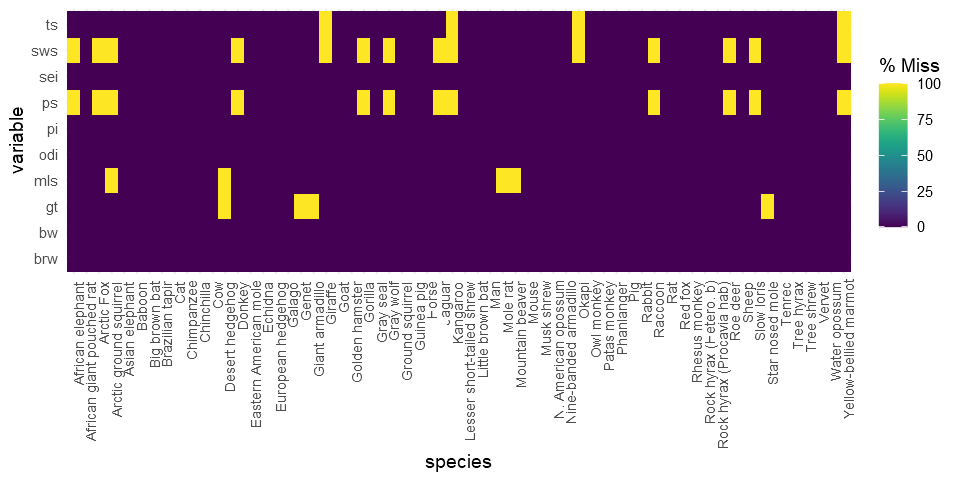

In [35]:
# require(naniar)
options(repr.plot.width = 8, repr.plot.height = 4)
gg_miss_fct(x=animals, fct=species) + 
theme(axis.text.x = element_text(angle=90, size=8))

## Determinate the Missingness Generation Mechanism
 
There are three mechanisms that generate Missing values:
 
1. Missing Completely at Random (MCAR)
2. Missing at Random (MAR)
3. Missing not at Random (MNAR)
 
We will investigate the missingness mechanisms using different techniques.


In [36]:
# require(MissMech)
animals2 <- animals[,c(4,5,7,8)]
miss1 <- TestMCARNormality(data=animals2)
miss1

Call:
TestMCARNormality(data = animals2)

Number of Patterns:  2 

Total number of cases used in the analysis:  53 

 Pattern(s) used:
          sws   ps   mls   gt   Number of cases
group.1    NA   NA     1    1                11
group.2     1    1     1    1                42


    Test of normality and Homoscedasticity:
  -------------------------------------------

Hawkins Test:

    P-value for the Hawkins test of normality and homoscedasticity:  0.001545358 

    Either the test of multivariate normality or homoscedasticity (or both) is rejected.
    Provided that normality can be assumed, the hypothesis of MCAR is 
    rejected at 0.05 significance level. 

Non-Parametric Test:

    P-value for the non-parametric test of homoscedasticity:  0.4279218 

    Reject Normality at 0.05 significance level.
    There is not sufficient evidence to reject MCAR at 0.05 significance level.

In [37]:
### Impute missing values

miss1 <- TestMCARNormality(data=animals2, , del.lesscases = 1, imputation.number = 10)
summary(miss1)



Number of imputation:  10 

Number of Patterns:  5 

Total number of cases used in the analysis:  60 

 Pattern(s) used:
          sws   ps   mls   gt   Number of cases
group.1    NA   NA     1    1                11
group.2     1    1     1    1                42
group.3     1    1     1   NA                 3
group.4    NA    1     1    1                 2
group.5     1    1    NA    1                 2


    Test of normality and Homoscedasticity:
  -------------------------------------------

Hawkins Test:

    P-value for the Hawkins test of normality and homoscedasticity:  0.0001877701 

Non-Parametric Test:

    P-value for the non-parametric test of homoscedasticity:  0.004675146 


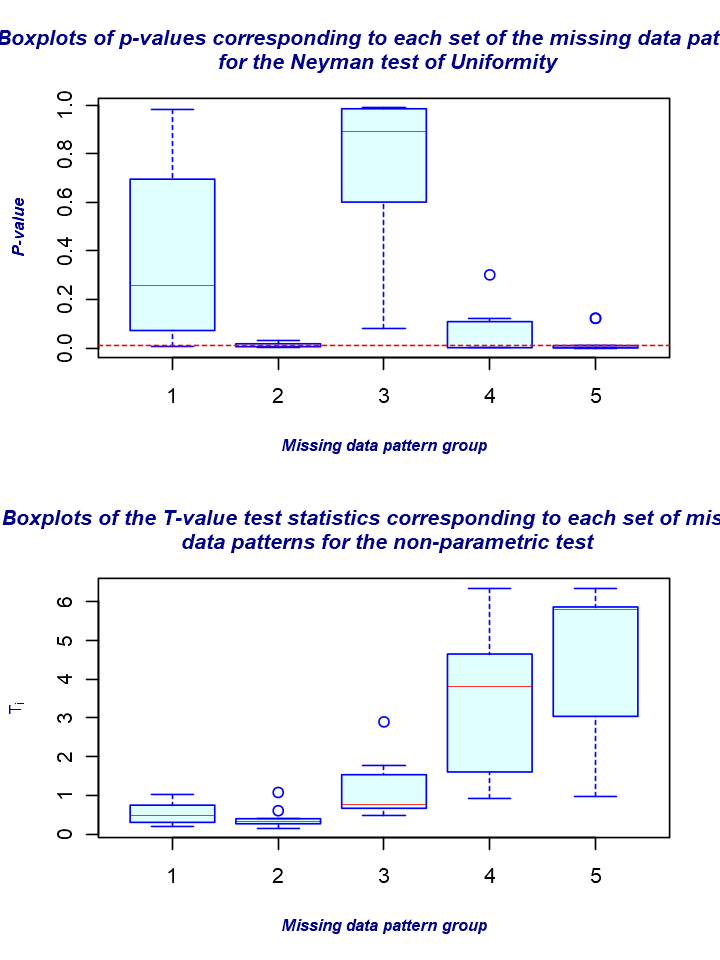

In [38]:
options(repr.plot.width = 6, repr.plot.height = 8)
boxplot(miss1)

In [39]:
summary(miss1$imputed.data)

animals.imp <- data.frame(miss1$imputed.data)
idx <- miss1$caseorder

head(animals.imp)
dim(animals.imp)

      sws               ps              mls                gt        
 Min.   :-3.857   Min.   :-1.369   Min.   :  2.000   Min.   :-50.85  
 1st Qu.: 6.250   1st Qu.: 0.900   1st Qu.:  6.875   1st Qu.: 34.50  
 Median : 8.350   Median : 1.616   Median : 16.250   Median : 79.00  
 Mean   : 8.373   Mean   : 1.840   Mean   : 20.056   Mean   :139.98  
 3rd Qu.:10.925   3rd Qu.: 2.400   3rd Qu.: 28.000   3rd Qu.:202.50  
 Max.   :17.900   Max.   : 6.600   Max.   :100.000   Max.   :645.00  

,sws,ps,mls,gt
,<dbl>,<dbl>,<dbl>,<dbl>
1,-3.857129,-1.368661,38.6,645
2,6.300000,2.000000,4.5,42
3,10.314407,1.858298,14.0,60
4,2.100000,1.800000,69.0,624
5,9.100000,0.700000,27.0,180
6,15.800000,3.900000,19.0,35


[1] 60  4

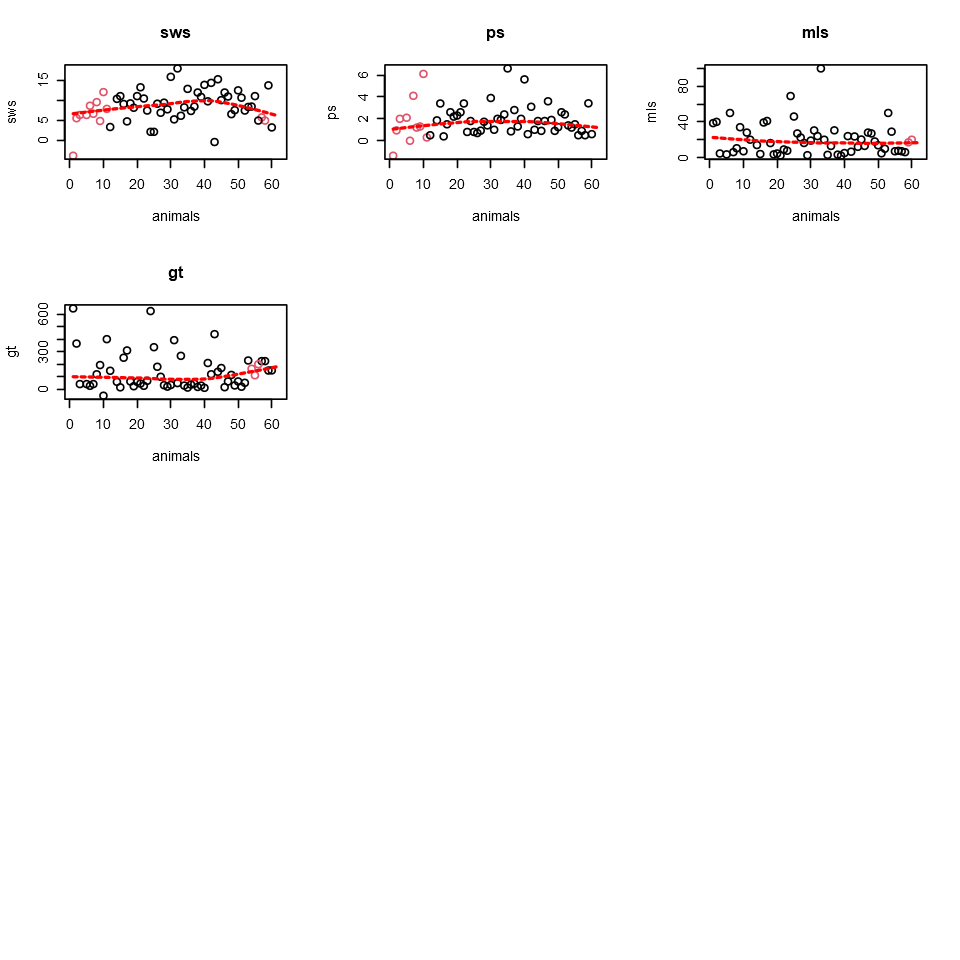

In [40]:
## Visualize the imputed missing values using scatter plots 
options(repr.plot.width = 8, repr.plot.height = 8)

misspoints <- missingMatrix(animals[idx,])
animals.imp <- data.frame(miss1$imputed.data)
par(mfrow=c(4,3))
for(v in names(animals2)) {
    scatter.smooth(animals.imp[[v]] ~ animals[idx,"species"], main=v, xlab="animals",ylab=v, family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints[idx,v]+1)
}
par(mfrow=c(1,1))


## MICE: Multiple Imputation with Chained Equations 

In [41]:
# library(mice)
init = mice(animals, maxit=0) 
meth = init$method
predM = init$predictorMatrix

In [42]:
meth

species      bw     brw     sws      ps      ts     mls      gt      pi     sei 
     ""      ""      ""   "pmm"   "pmm"   "pmm"   "pmm"   "pmm"      ""      "" 
    odi 
     ""

In [43]:
predM

,species,bw,brw,sws,ps,ts,mls,gt,pi,sei,odi
species,0,1,1,1,1,1,1,1,1,1,1
bw,1,0,1,1,1,1,1,1,1,1,1
brw,1,1,0,1,1,1,1,1,1,1,1
sws,1,1,1,0,1,1,1,1,1,1,1
ps,1,1,1,1,0,1,1,1,1,1,1
ts,1,1,1,1,1,0,1,1,1,1,1
mls,1,1,1,1,1,1,0,1,1,1,1
gt,1,1,1,1,1,1,1,0,1,1,1
pi,1,1,1,1,1,1,1,1,0,1,1
sei,1,1,1,1,1,1,1,1,1,0,1


In [44]:
### Pedict the missing values
set.seed(103)
imputed = mice(animals, method=meth, predictorMatrix=predM, m=5)


 iter imp variable
  1   1  sws*  ps*  ts*  mls*  gt*
  1   2  sws*  ps*  ts*  mls*  gt*
  1   3  sws*  ps*  ts*  mls*  gt*
  1   4  sws*  ps*  ts*  mls*  gt*
  1   5  sws*  ps*  ts*  mls*  gt*
  2   1  sws*  ps*  ts*  mls*  gt*
  2   2  sws*  ps*  ts*  mls*  gt*
  2   3  sws*  ps*  ts*  mls*  gt*
  2   4  sws*  ps*  ts*  mls*  gt*
  2   5  sws*  ps*  ts*  mls*  gt*
  3   1  sws*  ps*  ts*  mls*  gt*
  3   2  sws*  ps*  ts*  mls*  gt*
  3   3  sws*  ps*  ts*  mls*  gt*
  3   4  sws*  ps*  ts*  mls*  gt*
  3   5  sws*  ps*  ts*  mls*  gt*
  4   1  sws*  ps*  ts*  mls*  gt*
  4   2  sws*  ps*  ts*  mls*  gt*
  4   3  sws*  ps*  ts*  mls*  gt*
  4   4  sws*  ps*  ts*  mls*  gt*
  4   5  sws*  ps*  ts*  mls*  gt*
  5   1  sws*  ps*  ts*  mls*  gt*
  5   2  sws*  ps*  ts*  mls*  gt*
  5   3  sws*  ps*  ts*  mls*  gt*
  5   4  sws*  ps*  ts*  mls*  gt*
  5   5  sws*  ps*  ts*  mls*  gt*
 * Please inspect the loggedEvents 


Warning message:
"Number of logged events: 275"


In [45]:
summary(imputed)

Class: mids
Number of multiple imputations:  5 
Imputation methods:
species      bw     brw     sws      ps      ts     mls      gt      pi     sei 
     ""      ""      ""   "pmm"   "pmm"   "pmm"   "pmm"   "pmm"      ""      "" 
    odi 
     "" 
PredictorMatrix:
        species bw brw sws ps ts mls gt pi sei odi
species       0  1   1   1  1  1   1  1  1   1   1
bw            1  0   1   1  1  1   1  1  1   1   1
brw           1  1   0   1  1  1   1  1  1   1   1
sws           1  1   1   0  1  1   1  1  1   1   1
ps            1  1   1   1  0  1   1  1  1   1   1
ts            1  1   1   1  1  0   1  1  1   1   1
Number of logged events:  275 
  it im dep meth
1  1  1 sws  pmm
2  1  1 sws  pmm
3  1  1 sws  pmm
4  1  1  ps  pmm
5  1  1  ps  pmm
6  1  1  ps  pmm
                                                                                                                                                                                                                                    

In [46]:
summary(imputed$imp)
imp1 <- complete(imputed,1)
dim(imp1)

        Length Class      Mode
species 5      data.frame list
bw      5      data.frame list
brw     5      data.frame list
sws     5      data.frame list
ps      5      data.frame list
ts      5      data.frame list
mls     5      data.frame list
gt      5      data.frame list
pi      5      data.frame list
sei     5      data.frame list
odi     5      data.frame list

[1] 62 11

In [47]:
imputed.full <- complete(imputed,action="long")
dim(imputed.full)

[1] 310  13

In [48]:
## Check if there are any missing on the imputed data
sapply(imputed, function(x) sum(is.na(x)))

Warning message in is.na(x):
"is.na() applied to non-(list or vector) of type 'language'"


data             imp               m           where          blocks 
             38               0               0               0               0 
           call            nmis          method predictorMatrix   visitSequence 
              0               0               0               0               0 
       formulas            post           blots            seed       iteration 
              0               0               0               1               0 
  lastSeedValue       chainMean        chainVar    loggedEvents         version 
              0             150             150               0               0 
           date 
              0

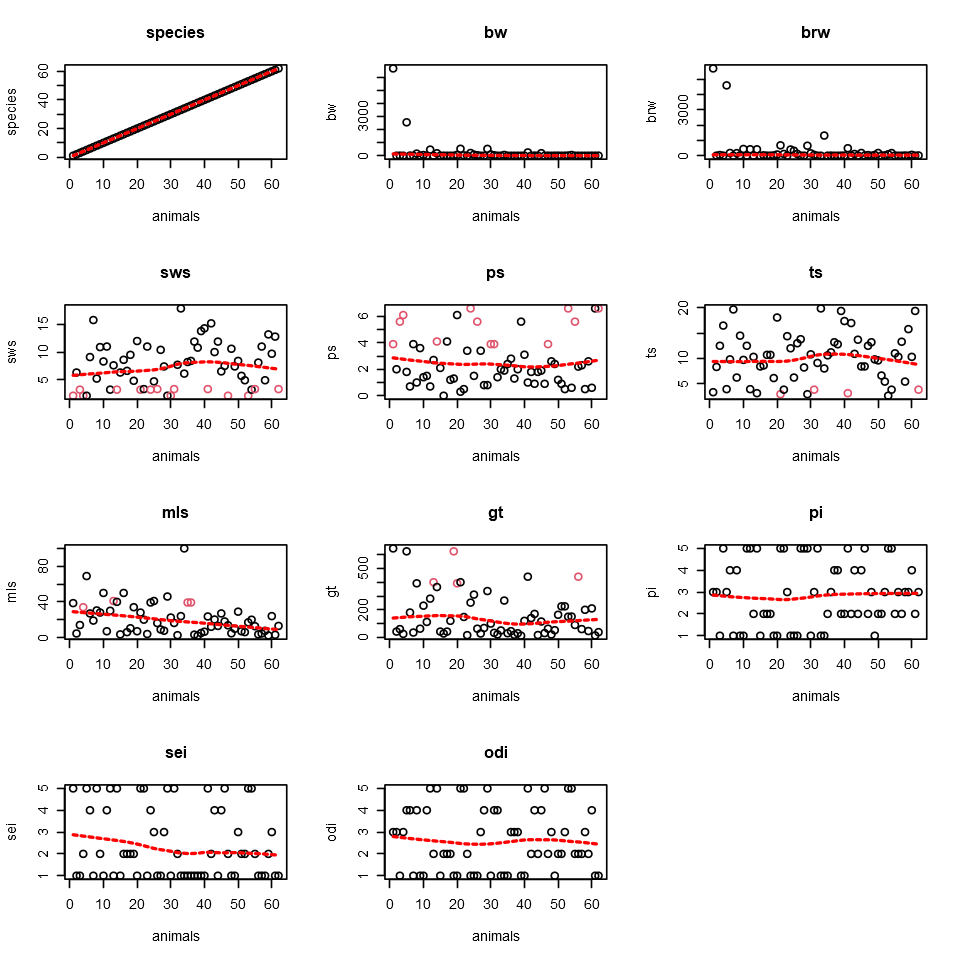

In [49]:
options(repr.plot.width = 8, repr.plot.height = 8)

misspoints <- missingMatrix(animals)
animals.imp <- complete(imputed,1)
par(mfrow=c(4,3))
for(v in names(animals)) {
    scatter.smooth(animals.imp[[v]] ~ animals[,"species"], main=v, xlab="animals",ylab=v, family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints[,v]+1)
}
par(mfrow=c(1,1))


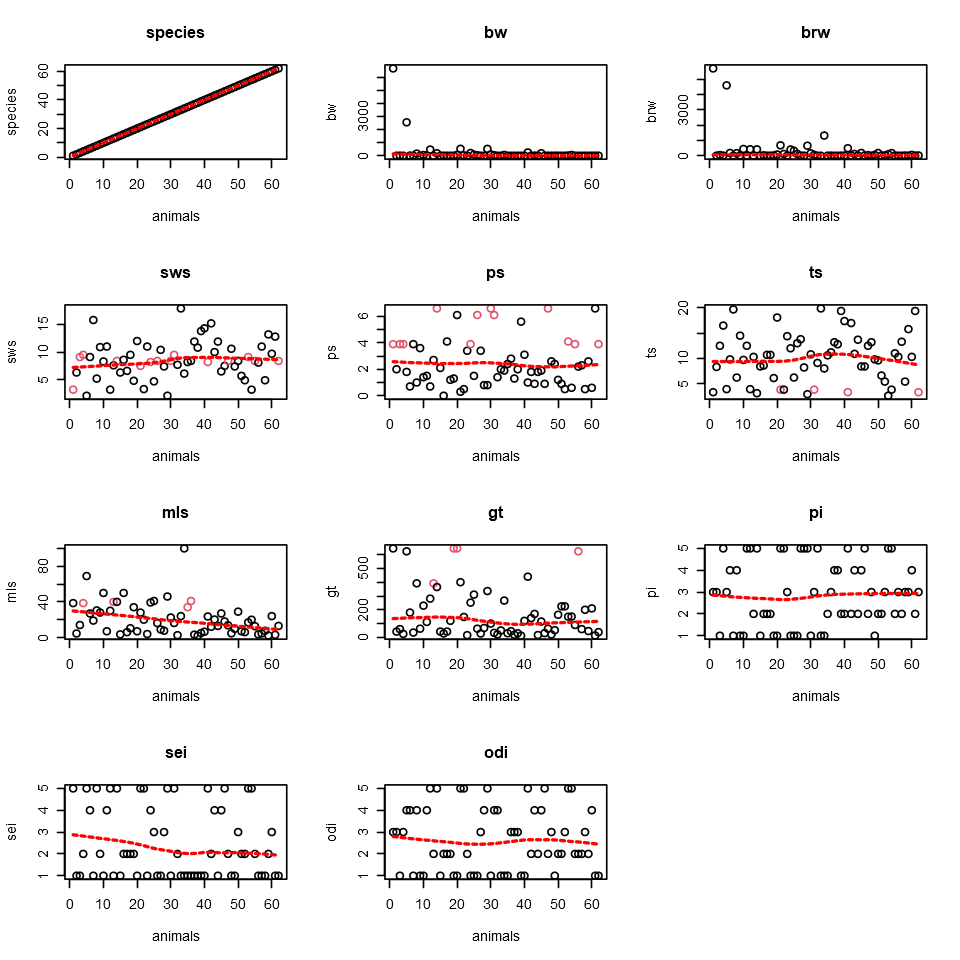

In [50]:
options(repr.plot.width = 8, repr.plot.height = 8)

misspoints <- missingMatrix(animals)
animals.imp <- complete(imputed,5)
par(mfrow=c(4,3))
for(v in names(animals)) {
    scatter.smooth(animals.imp[[v]] ~ animals[,"species"], main=v, xlab="animals",ylab=v, family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints[,v]+1)
}
par(mfrow=c(1,1))


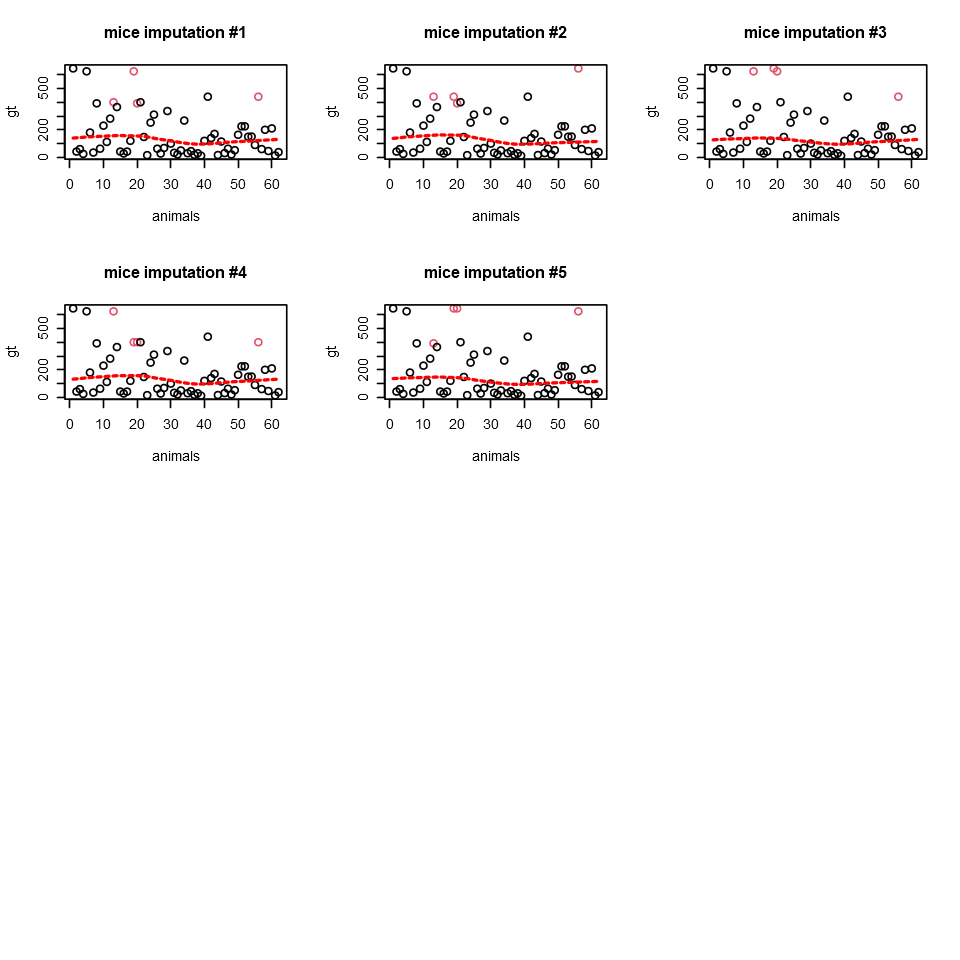

In [51]:
### gt on each of the five imputations
par(mfrow=c(4,3))

## mice imputation #1
scatter.smooth(complete(imputed,1)[["gt"]] ~ animals[,"species"], main="mice imputation #1", xlab="animals",ylab="gt", family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints$gt+1)

## mice imputation #2
scatter.smooth(complete(imputed,2)[["gt"]] ~ animals[,"species"], main="mice imputation #2", xlab="animals",ylab="gt", family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints$gt+1)

## mice imputation #3
scatter.smooth(complete(imputed,3)[["gt"]] ~ animals[,"species"], main="mice imputation #3", xlab="animals",ylab="gt", family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints$gt+1)

## mice imputation #4
scatter.smooth(complete(imputed,4)[["gt"]] ~ animals[,"species"], main="mice imputation #4", xlab="animals",ylab="gt", family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints$gt+1)

## mice imputation #5
scatter.smooth(complete(imputed,5)[["gt"]] ~ animals[,"species"], main="mice imputation #5", xlab="animals",ylab="gt", family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2), col=misspoints$gt+1)

par(mfrow=c(1,1))


# Propensity Score

In [52]:
## require(MatchIt)

animals2 <- animals[,c('species', 'bw', 'brw', 'pi', 'sei', 'odi')]
animals2$sws_miss <- ifelse(is.na(animals$sws)==T, 1, 0)
summary(animals2)

                      species         bw                brw         
 African elephant         : 1   Min.   :   0.005   Min.   :   0.14  
 African giant pouched rat: 1   1st Qu.:   0.600   1st Qu.:   4.25  
 Arctic Fox               : 1   Median :   3.342   Median :  17.25  
 Arctic ground squirrel   : 1   Mean   : 198.790   Mean   : 283.13  
 Asian elephant           : 1   3rd Qu.:  48.202   3rd Qu.: 166.00  
 Baboon                   : 1   Max.   :6654.000   Max.   :5712.00  
 (Other)                  :56                                       
       pi             sei             odi           sws_miss     
 Min.   :1.000   Min.   :1.000   Min.   :1.000   Min.   :0.0000  
 1st Qu.:2.000   1st Qu.:1.000   1st Qu.:1.000   1st Qu.:0.0000  
 Median :3.000   Median :2.000   Median :2.000   Median :0.0000  
 Mean   :2.871   Mean   :2.419   Mean   :2.613   Mean   :0.2258  
 3rd Qu.:4.000   3rd Qu.:4.000   3rd Qu.:4.000   3rd Qu.:0.0000  
 Max.   :5.000   Max.   :5.000   Max.   :5.000   Max

In [53]:
m.out <- matchit(sws_miss ~ bw + brw + pi + sei + odi, data = animals2, method = "nearest", ratio = 1)
summary(m.out)



Call:
matchit(formula = sws_miss ~ bw + brw + pi + sei + odi, data = animals2, 
    method = "nearest", ratio = 1)

Summary of balance for all data:
         Means Treated Means Control SD Control Mean Diff eQQ Med eQQ Mean
distance        0.3334        0.1944     0.1161    0.1389  0.0994   0.1380
bw            573.3788       89.5349   376.8333  483.8439 33.9900 374.4130
brw           589.7571      193.7025   687.8002  396.0546 98.6500 202.4236
pi              3.0000        2.8333     1.4192    0.1667  0.0000   0.2857
sei             3.1429        2.2083     1.4869    0.9345  1.0000   1.0000
odi             2.7857        2.5625     1.3669    0.2232  0.0000   0.3571
           eQQ Max
distance    0.4836
bw       4107.0000
brw      1109.0000
pi          1.0000
sei         3.0000
odi         1.0000


Summary of balance for matched data:
         Means Treated Means Control SD Control Mean Diff eQQ Med eQQ Mean
distance        0.3334        0.2812     0.1186    0.0522  0.0026   0.0546
bw 

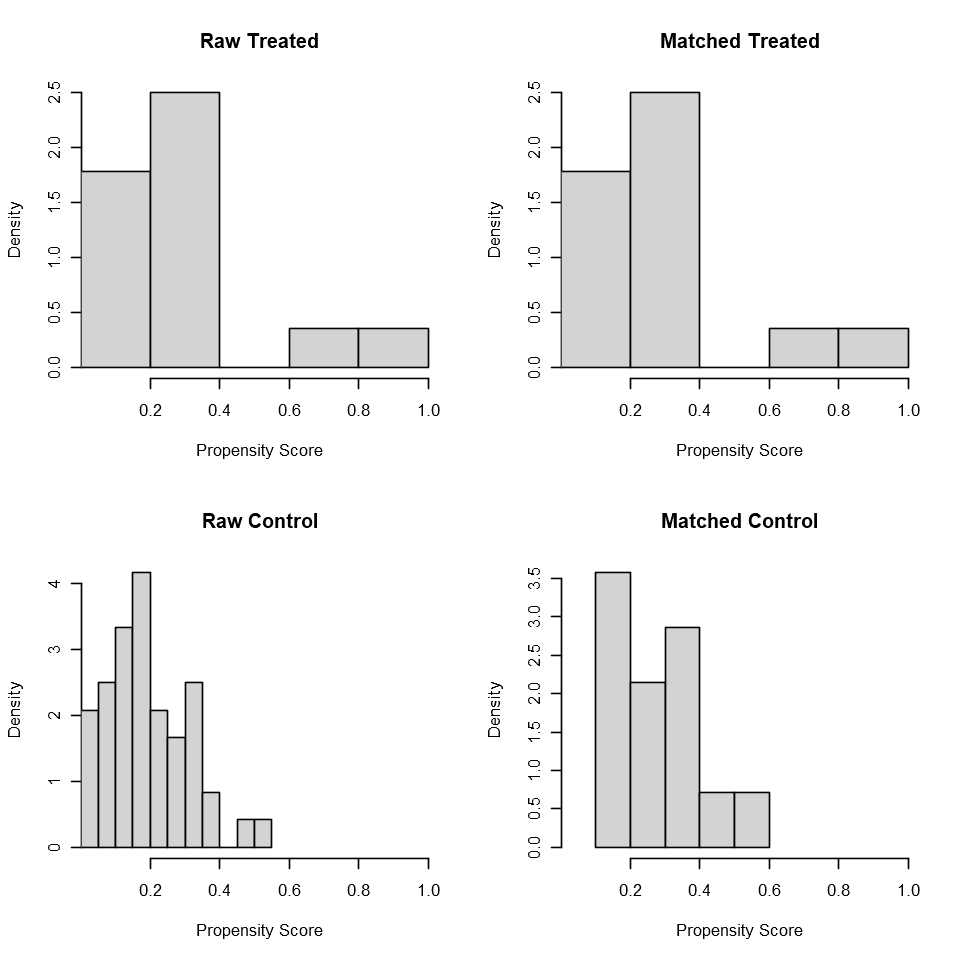

In [54]:
  options(repr.plot.width = 8, repr.plot.height = 8)
plot(m.out, type = "hist")

The MatchIt package has many methods for propensity score matching:
 
1. "exact" - matches each treated unit with a control unit that has exactly the same values on each covariate.
2. "subclass" - breaks the data set into subclasses such that the distributions of the covariates are similar in each subclass 
3. "nearest" - matches a treated unit to a control unit by means of that is closest in terms of a distance measure (nearest neighbor)
4. "optimal" - focuses on minimizing the average absolute distance across all matched pairs 
5. "genetic" - uses a computationally intensive genetic search algorithm to match treatment and control units 
6. "cem" - (Coarsened Exact Matching) matches on a covariate while maintaining the balance of other covariates
 


In [55]:
animals.matched <- match.data(m.out) 
animals.matched %>% arrange(distance)


,species,bw,brw,pi,sei,odi,sws_miss,distance,weights
,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
5,Asian elephant,2547.000,4603.0,3,5,4,0,0.1364069,1
26,Gray wolf,36.330,119.5,1,1,1,1,0.1446241,1
49,Red fox,4.235,50.4,1,1,1,0,0.1484034,1
3,Arctic Fox,3.385,44.5,1,1,1,1,0.1491213,1
30,Jaguar,100.000,157.0,1,1,1,1,0.1520995,1
15,Eastern American mole,0.075,1.2,1,1,1,0,0.1551043,1
47,Raccoon,4.288,39.2,2,2,2,1,0.1833494,1
16,Echidna,3.000,25.0,2,2,2,0,0.1855885,1
51,Rock hyrax (Hetero. b),0.750,12.3,2,2,2,0,0.1873356,1
